In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
# import hypergrad as hg
from mlmodel import *
import utils
import numpy as np
from sparsemax import Sparsemax
from argparse import ArgumentParser
from ZSTL_model import ZSTL

In [2]:
sineRegress = FuncRecursiveNet([
        FLinearLayer(40, True),
        FActivation(F.relu),
        FLinearLayer(40, True),
        FActivation(F.relu),
        FLinearLayer(1, True)
    ])

In [3]:
kb_size = 10
train_size = 90

In [4]:
filename = 'sineWave_xl.p'
with open(filename, 'rb') as f:
    dataset = pickle.load(f)
total_len = len(dataset)
test_size = total_len - kb_size - train_size

flatted_param, shape_record = utils.flattenParam(dataset[0])
print(shape_record)

#data = Dataset(dataset)
indx = [ x for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
#print(temp)
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
# val_indx = list(np.random.choice(temp, size=55, replace=False))
test_indx = temp
print(len(test_indx))

support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])



{0: [(40, 1)], 1: [(40,)], 2: [(40, 40)], 3: [(40,)], 4: [(1, 40)], 5: [(1,)]}
10
90
44


In [5]:
print(dataset[0][0])
print(type(dataset[0][1]))
print(dataset[0][0], len(dataset[0][1]), len(dataset[0][2]), len(dataset[0][3]))

(0.4, 1, 0.0)
<class 'list'>
(0.4, 1, 0.0) 6 200 200


In [6]:
support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=15, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
print(support_a.size(), support_w.size(), support_x.size(), support_y.size())

torch.Size([10, 1, 3]) torch.Size([10, 1, 1761]) torch.Size([10, 200, 1]) torch.Size([10, 200, 1])


tensor([1.4000, 1.0000, 4.3197])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.3749998807907104pi, pred loss=0.0


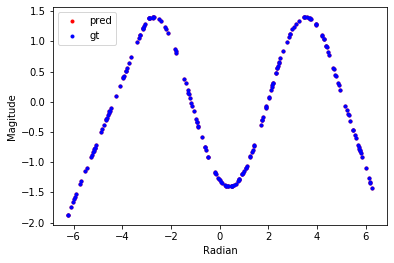

In [7]:
#test visualization and rehspae uitls
item = [support_a[0,:].float(), support_w[0,:].float(), support_x[0,:].float(), support_y[0,:].float()]
utils.taskVisualize(item, sineRegress, shape_record)

In [9]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
print(support_a.size())
dm = support_a.size()[0]

param_dict = {}
param_dict['rho'] = 0.0005
param_dict['mu'] = 0.0001
param_dict['loss'] = 'mse'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = 1761
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'


ZSTL_model = ZSTL(support_w, support_a, support_x, sineRegress, param_dict)

torch.Size([3, 10])


atten align 0.027888890355825424
360/2000 o_loss 0.5894359027345974; mean test loss 0.30351169138554146 with mse loss in atten align 0.02427249774336815
370/2000 o_loss 0.48501957952976227; mean test loss 0.3226367120038379 with mse loss in atten align 0.01916046254336834
380/2000 o_loss 0.47111917436122897; mean test loss 0.3238325124098496 with mse loss in atten align 0.02376559004187584
390/2000 o_loss 0.5468400639792284; mean test loss 0.32886213481172244 with mse loss in atten align 0.020013829693198204
400/2000 o_loss 0.45120586156845094; mean test loss 0.2977491423106668 with mse loss in atten align 0.025786142796278
410/2000 o_loss 0.5625354268898566; mean test loss 0.2882316201099787 with mse loss in atten align 0.019519802182912827
420/2000 o_loss 0.5068170463045438; mean test loss 0.2936141519934278 with mse loss in atten align 0.026294700801372528
430/2000 o_loss 0.4246366114666065; mean test loss 0.3043391604018821 with mse loss in atten align 0.025334062054753304
440/2000

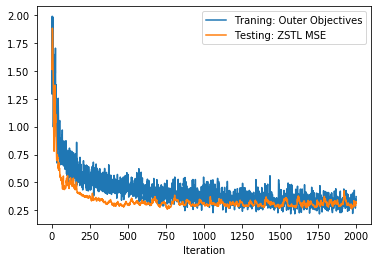

0

In [9]:
ZSTL_model.train(train_loader, test_loader, max_iter=2000)

tensor([1.8000, 1.0000, 3.5343])
pred_y shape torch.Size([200, 1])
Amplitude A=1.7999999523162842, Frequency f=1.0, phase=1.125pi, pred loss=0.27030354738235474


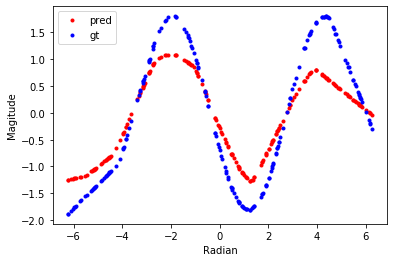

tensor([0.8000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=0.5pi, pred loss=0.4844467341899872


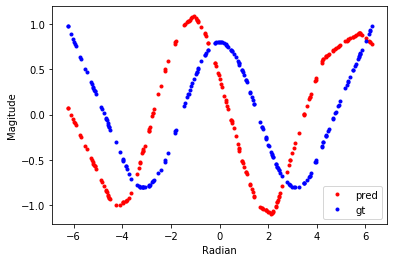

tensor([0.8000, 1.0000, 5.1051])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=1.625pi, pred loss=0.16809390485286713


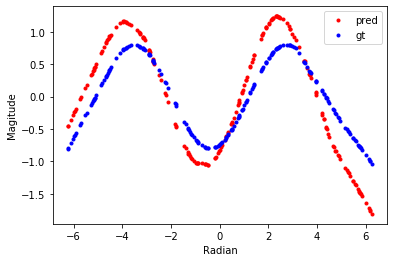

tensor([0.6000, 1.0000, 5.4978])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.7499998807907104pi, pred loss=0.21504133939743042


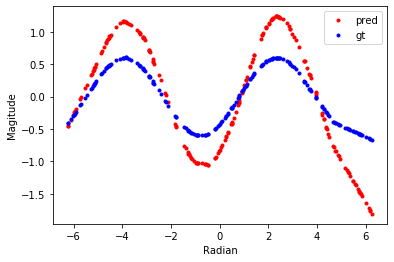

tensor([0.4000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=0.5pi, pred loss=0.4168207049369812


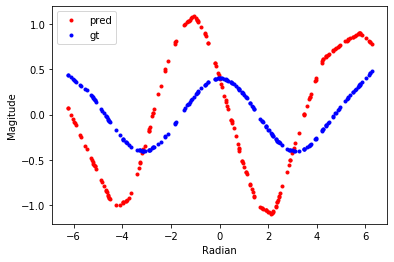

tensor([1.6000, 1.0000, 1.9635])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=0.625pi, pred loss=0.6263487339019775


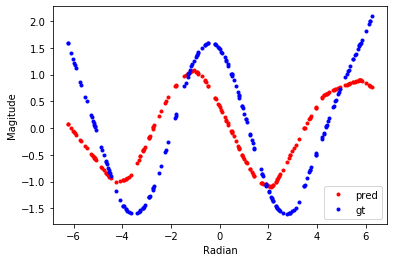

tensor([1.8000, 1.0000, 1.9635])
pred_y shape torch.Size([200, 1])
Amplitude A=1.7999999523162842, Frequency f=1.0, phase=0.625pi, pred loss=0.8237240314483643


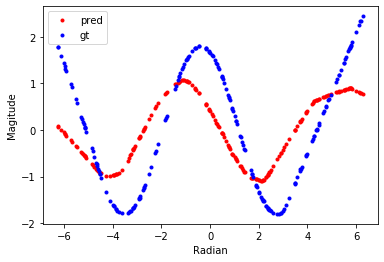

tensor([2.0000, 1.0000, 0.7854])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=0.25pi, pred loss=0.4546525478363037


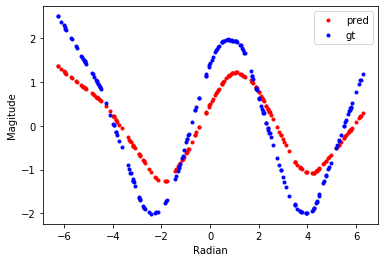

tensor([0.4000, 1.0000, 2.7489])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=0.8749999403953552pi, pred loss=0.18688899278640747


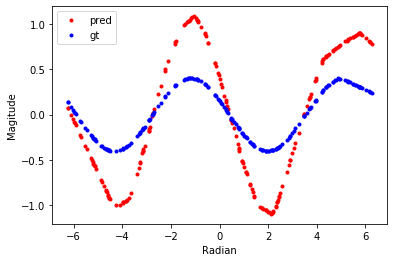

tensor([0.6000, 1.0000, 5.1051])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.625pi, pred loss=0.2581861615180969


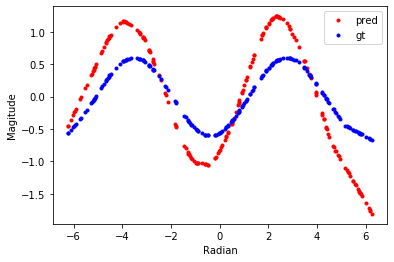

tensor([1.4000, 1.0000, 1.9635])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=0.625pi, pred loss=0.46921107172966003


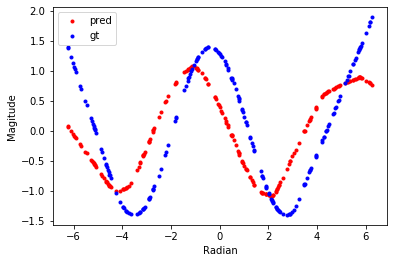

tensor([1.8000, 1.0000, 0.3927])
pred_y shape torch.Size([200, 1])
Amplitude A=1.7999999523162842, Frequency f=1.0, phase=0.125pi, pred loss=0.1725286841392517


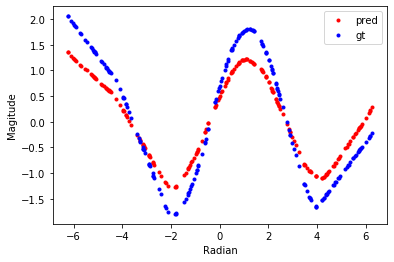

tensor([0.4000, 1.0000, 3.5343])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.125pi, pred loss=0.3150683045387268


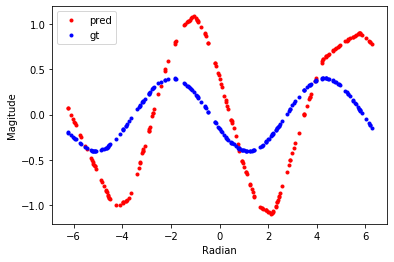

tensor([1.4000, 1.0000, 2.7489])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=0.8749999403953552pi, pred loss=0.07589125633239746


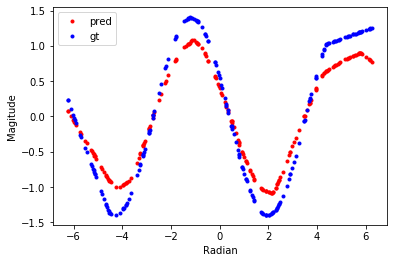

tensor([0.4000, 1.0000, 5.1051])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.625pi, pred loss=0.3905297815799713


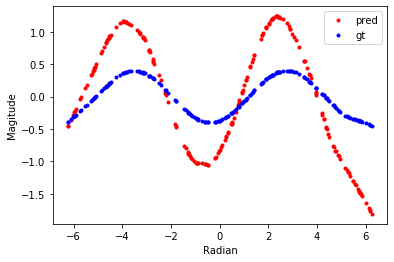

tensor([1.2000, 1.0000, 4.7124])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=1.5pi, pred loss=0.10335377603769302


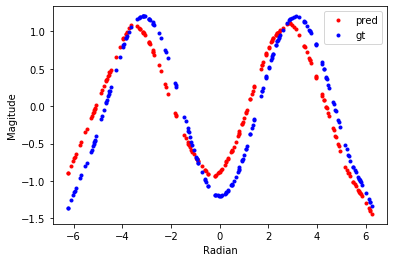

tensor([2.0000, 1.0000, 1.1781])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=0.375pi, pred loss=0.9140027761459351


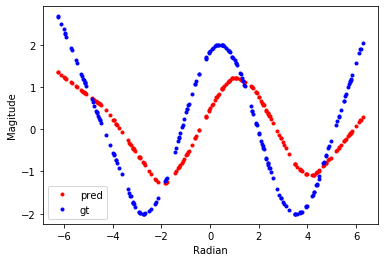

tensor([1., 1., 0.])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.0pi, pred loss=0.15631884336471558


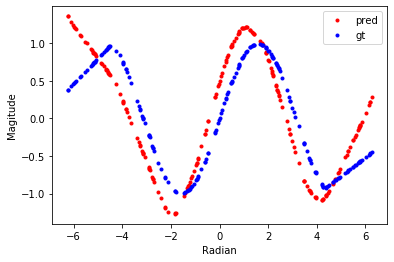

tensor([2.0000, 1.0000, 5.4978])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.7499998807907104pi, pred loss=0.3047478497028351


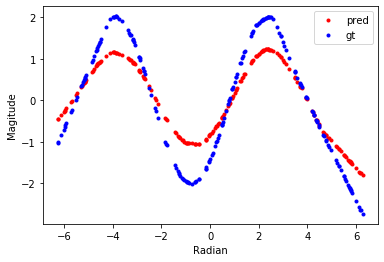

tensor([0.6000, 1.0000, 0.3927])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=0.125pi, pred loss=0.14879044890403748


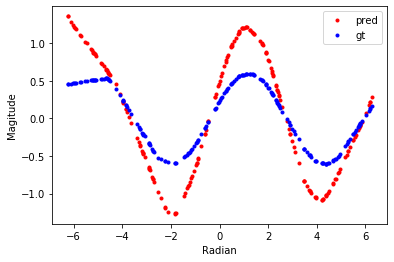

tensor([1.0000, 1.0000, 5.1051])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=1.625pi, pred loss=0.11781487613916397


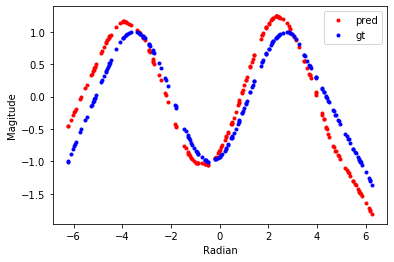

tensor([1.2000, 1.0000, 1.9635])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=0.625pi, pred loss=0.35139000415802


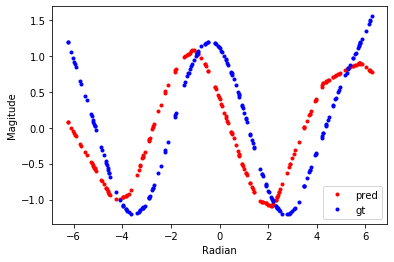

tensor([1.0000, 1.0000, 1.9635])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.625pi, pred loss=0.27457788586616516


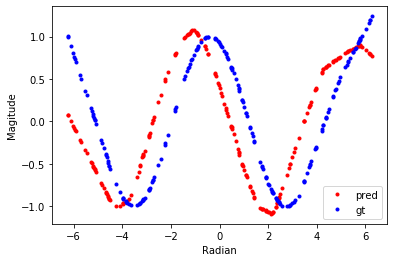

tensor([1.2000, 1.0000, 5.8905])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=1.875pi, pred loss=0.1406923532485962


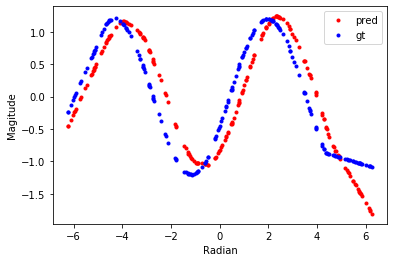

tensor([1.2000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=0.5pi, pred loss=0.6485524773597717


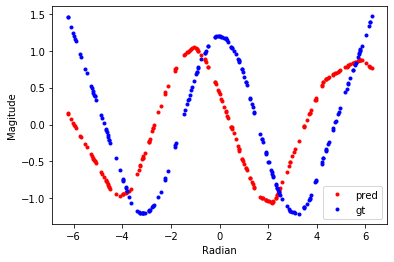

tensor([1.4000, 1.0000, 4.7124])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.5pi, pred loss=0.2808659076690674


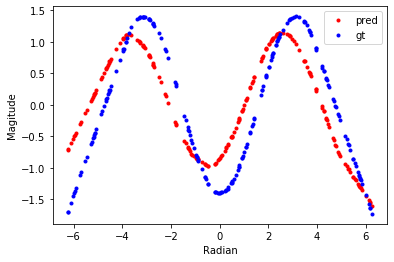

tensor([1.6000, 1.0000, 3.5343])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.125pi, pred loss=0.15611086785793304


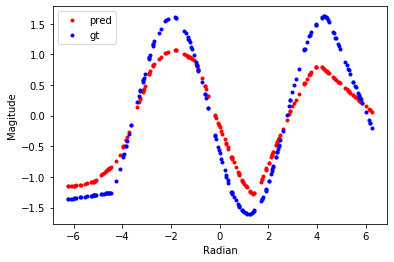

tensor([0.6000, 1.0000, 3.9270])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.25pi, pred loss=0.13645769655704498


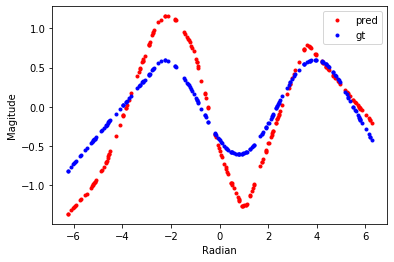

tensor([1.4000, 1.0000, 3.1416])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.0pi, pred loss=0.17720703780651093


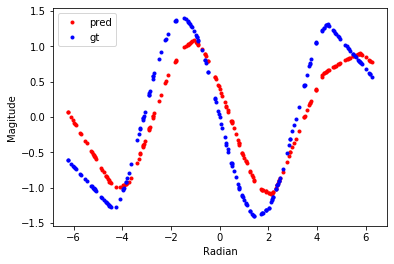

tensor([1.8000, 1.0000, 1.1781])
pred_y shape torch.Size([200, 1])
Amplitude A=1.7999999523162842, Frequency f=1.0, phase=0.375pi, pred loss=0.71451336145401


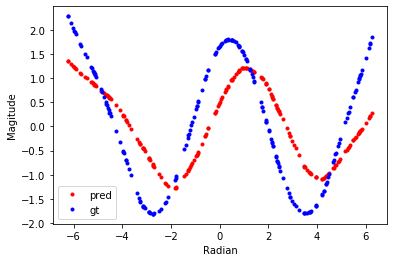

tensor([0.6000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=0.5pi, pred loss=0.4306979179382324


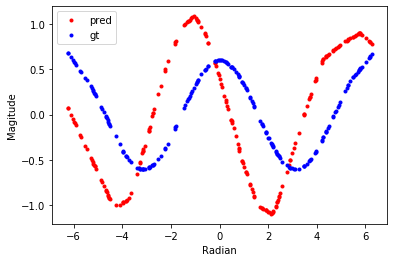

tensor([1.2000, 1.0000, 1.1781])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=0.375pi, pred loss=0.12013445049524307


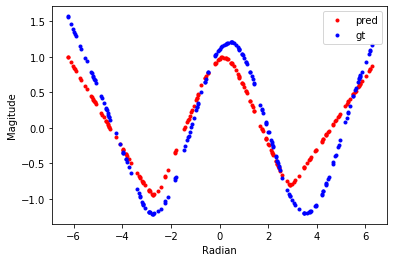

tensor([0.4000, 1.0000, 5.4978])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.7499998807907104pi, pred loss=0.3638932704925537


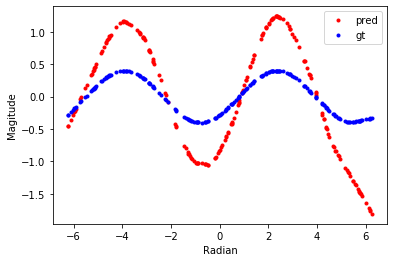

tensor([0.4000, 1.0000, 3.9270])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.25pi, pred loss=0.24134059250354767


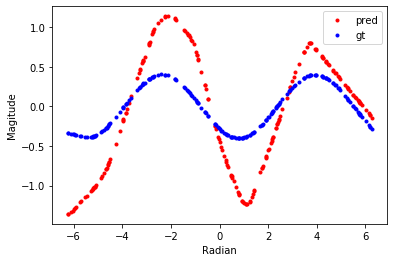

tensor([1.0000, 1.0000, 2.7489])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.8749999403953552pi, pred loss=0.006654974073171616


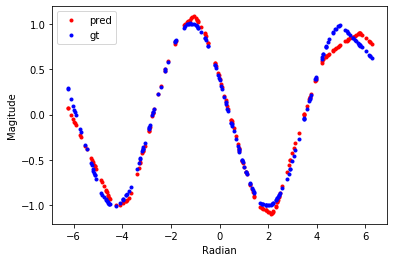

tensor([0.6000, 1.0000, 3.1416])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.0pi, pred loss=0.14243263006210327


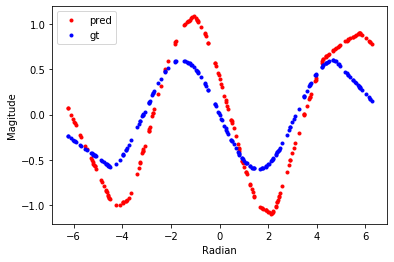

tensor([2.0000, 1.0000, 3.9270])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.25pi, pred loss=0.5998798608779907


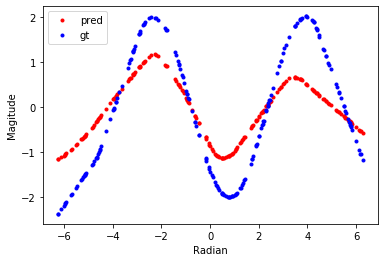

tensor([0.8000, 1.0000, 2.3562])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=0.75pi, pred loss=0.07821071892976761


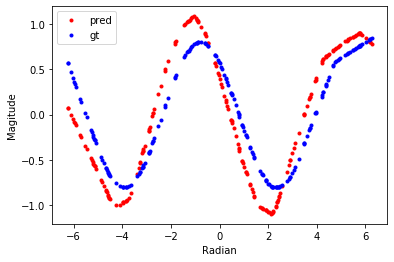

tensor([1.6000, 1.0000, 2.3562])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=0.75pi, pred loss=0.30780401825904846


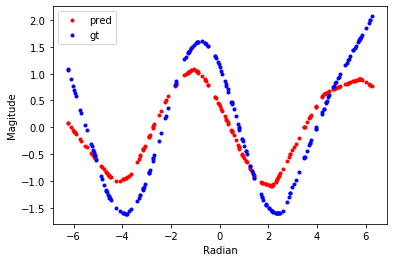

tensor([0.6000, 1.0000, 3.5343])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.125pi, pred loss=0.27988401055336


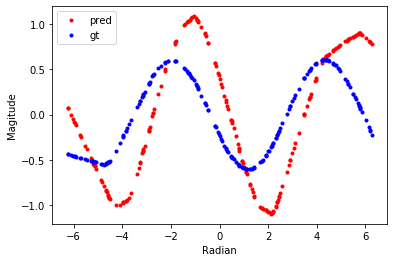

tensor([0.8000, 1.0000, 1.1781])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=0.375pi, pred loss=0.07108364999294281


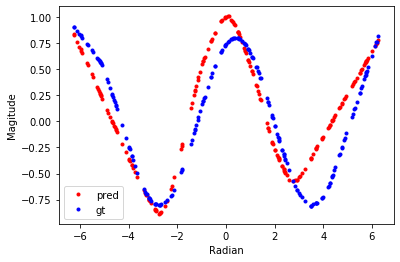

tensor([0.8000, 1.0000, 0.7854])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=0.25pi, pred loss=0.056572746485471725


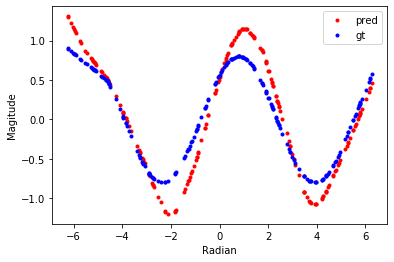

tensor([1.4000, 1.0000, 5.4978])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.7499998807907104pi, pred loss=0.03760600835084915


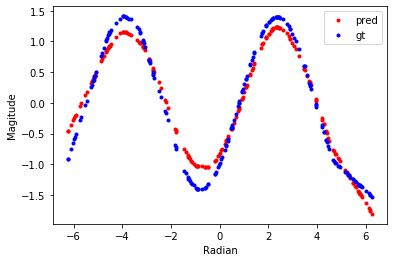

tensor([2.0000, 1.0000, 1.9635])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=0.625pi, pred loss=1.0607571601867676


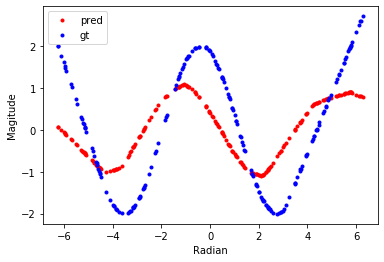

In [10]:
test_batch = next(iter(test_loader))
test_a, test_w, test_x, test_y = test_batch[0].float(), test_batch[1].float(), test_batch[2].float(), test_batch[3].float()
test_a = test_a.squeeze().t()
test_w = test_w.squeeze().t()

test_w_pred = ZSTL_model.task_transfer(test_a, ZSTL_model.a_kb_opt)
test_batch_size = test_w_pred.size()[1]
tt_w = test_w_pred.clone().detach()


for t in range(test_batch_size):
  item = [test_a[:,t].float(), tt_w[:,t].float().unsqueeze(0), test_x[t,:].float(), test_y[t,:].float()]
  utils.taskVisualize(item, sineRegress, shape_record)

In [17]:
ZSTL_model1 = ZSTL(support_w, support_a, support_x, sineRegress, param_dict)
print(shape_record)
ZSTL_model1.train(train_loader, test_loader, max_iter=2000)


TypeError: __init__() missing 1 required positional argument: 'param_dict'